# Processus Gaussien pour prédiction poids

### Librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

### Données brutes

In [2]:
file_save = os.getcwd() + "/data/dataset.csv"

with open(file_save, 'r') as f:
    df = pd.read_csv(file_save, index_col=0)

In [3]:
df

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2020-08-09,107.250000,37.190000,NaN,NaN,NaN,0.346760,1883.296000,1861.3,71.3,245.0,66.1,0.00,0.0,0.000000,1883.296000,-21.996000
2020-08-11,104.650000,33.150000,NaN,NaN,NaN,0.316770,1914.400000,1772.4,50.5,185.8,104.1,0.00,0.0,0.000000,1914.400000,-142.000000
2020-08-12,104.350000,33.800000,NaN,NaN,NaN,0.323910,1893.880000,1894.3,59.3,220.3,87.5,0.00,0.0,0.000000,1893.880000,0.420000
2020-08-13,104.400000,34.340000,NaN,NaN,NaN,0.328927,1883.296000,1822.6,71.5,227.7,70.2,0.00,0.0,0.000000,1883.296000,-60.696000
2020-08-14,104.500000,33.850000,NaN,NaN,NaN,0.323923,1896.040000,1891.5,61.8,217.2,82.5,0.00,0.0,0.000000,1896.040000,-4.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-15,70.258750,11.072500,2.961250,56.208750,39.525000,0.157596,1648.423000,1654.8,45.5,135.1,186.2,3671.21,396.0,325.957095,1974.380095,-319.580095
2023-11-16,70.404286,11.120000,2.967143,56.301429,39.607143,0.157945,1650.540571,1778.7,54.4,128.2,204.9,0.00,0.0,0.000000,1650.540571,128.159429
2023-11-17,70.067500,10.775000,2.968750,56.306250,39.705000,0.153780,1650.718000,1750.0,68.7,96.5,199.2,1134.11,113.0,91.332225,1742.050225,7.949775
2023-11-18,70.686667,10.971111,2.990000,56.710000,40.076667,0.155208,1659.856000,1889.9,67.6,161.3,170.6,5700.00,453.0,343.495611,2003.351611,-113.451611


In [4]:
# clean-up
df1 = df.copy(deep=True)
columns_to_drop = ['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique', 'MG%', 'BMR', 'Lipides', 'Glucides', 'Proteines', 'exo_duree', 'exo_cals_bruts', 'Depense_cal_totale', 'cal_deficit']
df1.drop(columns=columns_to_drop, inplace=True)

In [5]:
df1

,Masse_Totale,Masse_Grasse,Calories,exo_cals_nets
2020-08-09,107.250000,37.190000,1861.3,0.000000
2020-08-11,104.650000,33.150000,1772.4,0.000000
2020-08-12,104.350000,33.800000,1894.3,0.000000
2020-08-13,104.400000,34.340000,1822.6,0.000000
2020-08-14,104.500000,33.850000,1891.5,0.000000
...,...,...,...,...
2023-11-15,70.258750,11.072500,1654.8,325.957095
2023-11-16,70.404286,11.120000,1778.7,0.000000
2023-11-17,70.067500,10.775000,1750.0,91.332225
2023-11-18,70.686667,10.971111,1889.9,343.495611


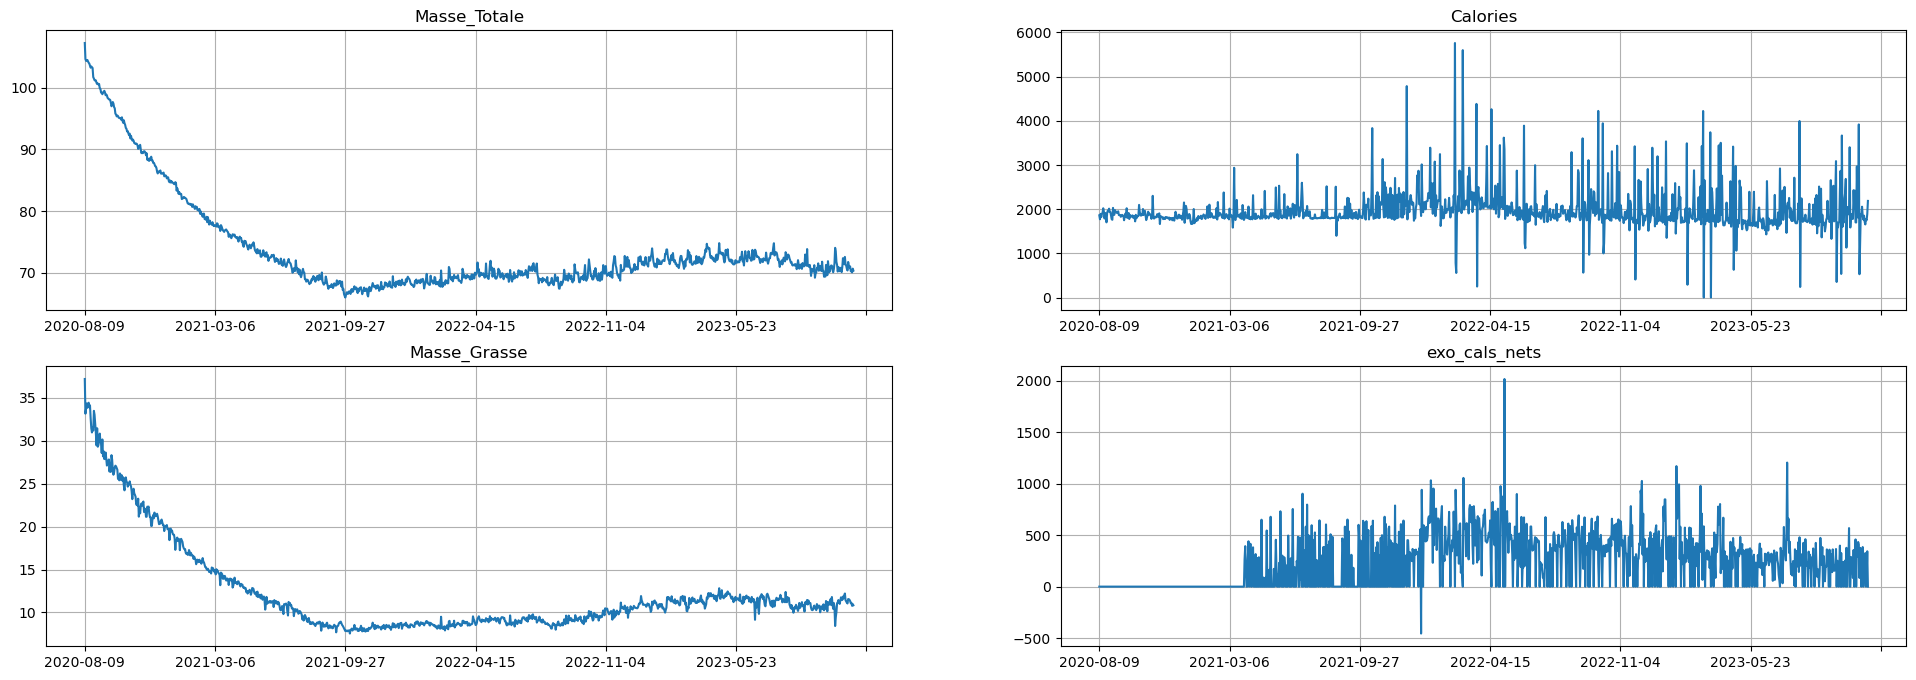

In [6]:
# Visu

fig, axs = plt.subplots(2,2,figsize=(24,8))

for i,name in enumerate(df1.columns):
    r = i%2
    c = i//2
    axs[r,c].set_title(name)
    df1[name].plot(ax=axs[r,c])
    axs[r,c].grid(True)

In [ ]:
# need to check that datapoints follow by one day
# and deal with holes

## Création du dataset

### Step 1 : moyennage des données

In [7]:
length_average = 3

In [8]:
def get_df_moyenne(df, length_average=length_average):
    """prend la dataframe et moyenne les valeurs suivant length_average"""
    df = df.rolling(window=length_average).mean()
    df.dropna(inplace=True)
    return df

In [9]:
df2 = get_df_moyenne(df1)

df2

,Masse_Totale,Masse_Grasse,Calories,exo_cals_nets
2020-08-12,105.416667,34.713333,1842.666667,0.000000
2020-08-13,104.466667,33.763333,1829.766667,0.000000
2020-08-14,104.416667,33.996667,1869.466667,0.000000
2020-08-15,104.383333,34.156667,1879.800000,0.000000
2020-08-16,104.266667,34.186667,1946.166667,0.000000
...,...,...,...,...
2023-11-15,70.715139,11.291944,1741.266667,262.986866
2023-11-16,70.573234,11.174907,1716.266667,192.706969
2023-11-17,70.243512,10.989167,1727.833333,139.096440
2023-11-18,70.386151,10.955370,1806.200000,144.942612


### Step 2 : create targets, which are next days's Masse_Totale and Masse_Grasse values

In [10]:
df2 = pd.concat([df2.shift(1), df2['Masse_Totale'], df2['Masse_Grasse']], axis=1)
df2.columns = ['MT', 'MG', 'Cals', 'Exos', 'MT+1', 'MG+1']
df2.dropna(inplace=True)

df2

### Step 3 : date de démarrage des données d'entraînement

In [12]:
year = 2020
month = 9
day = 1

In [13]:
from datetime import datetime

def crop_dataset(df=df2, year=year, month=month, day=day):
    """supprime les données avant year,month, date
    """
    df.index = pd.to_datetime(df.index)
    df = df[df.index >= datetime(year=year, month=month, day=day)]
    return df

In [14]:
df2 = crop_dataset().copy(deep=True)

df2

,MT,MG,Cals,Exos,MT+1,MG+1
2020-09-01,102.141667,32.075556,1945.366667,0.000000,101.483333,32.562222
2020-09-02,101.483333,32.562222,1977.633333,0.000000,101.291667,32.815000
2020-09-03,101.291667,32.815000,1968.066667,0.000000,101.191667,31.965000
2020-09-04,101.191667,31.965000,1963.266667,0.000000,101.050000,30.778333
2020-09-05,101.050000,30.778333,1909.366667,0.000000,100.866667,30.613333
...,...,...,...,...,...,...
2023-11-15,71.032963,11.449259,1778.100000,154.334501,70.715139,11.291944
2023-11-16,70.715139,11.291944,1741.266667,262.986866,70.573234,11.174907
2023-11-17,70.573234,11.174907,1716.266667,192.706969,70.243512,10.989167
2023-11-18,70.243512,10.989167,1727.833333,139.096440,70.386151,10.955370


### Step 4 : Construit les train et test sets

In [15]:
X = df2[['MT', 'MG', 'Cals', 'Exos']]
y_mt = df2['MT+1']
y_mg = df2['MG+1']

In [16]:
# longueur du test set

LAST = 90

In [17]:
X_train = X[:-LAST]
X_test = X[-LAST:]

y_mt_train = y_mt[:-LAST]
y_mt_test = y_mt[-LAST:]

y_mg_train = y_mg[:-LAST]
y_mg_test = y_mg[-LAST:]

### Instancie un GP par output

In [18]:
# Gaussian process

def get_gpr(length_scale=7, length_scale_bounds=(1e-1, 1e4), noise_level=2.0, noise_level_bounds=(1e-6, 1e2)):
    """Instancie un GPR avec un kernel Gaussien + kernel bruit blanc"""

    kernel = RBF(
        length_scale=length_scale,
        length_scale_bounds=length_scale_bounds
        ) \
        + WhiteKernel(
            noise_level=noise_level,
            noise_level_bounds=noise_level_bounds
            )
    gpr = GaussianProcessRegressor(kernel = kernel, alpha=0.0, random_state=42, normalize_y=True, n_restarts_optimizer=9 )
    
    return gpr, kernel

In [19]:
gpr_mt, kernel_mt = get_gpr()
gpr_mg, kernel_mg = get_gpr()

### Training

In [20]:
gpr_mt.fit(X_train, y_mt_train)

GaussianProcessRegressor(alpha=0.0,
                         kernel=RBF(length_scale=7) + WhiteKernel(noise_level=2),
                         n_restarts_optimizer=9, normalize_y=True,
                         random_state=42)

In [21]:
gpr_mg.fit(X_train, y_mg_train)

GaussianProcessRegressor(alpha=0.0,
                         kernel=RBF(length_scale=7) + WhiteKernel(noise_level=2),
                         n_restarts_optimizer=9, normalize_y=True,
                         random_state=42)

In [22]:
mean_prediction_mt, std_prediction_mt = gpr_mt.predict(X_train, return_std=True)

In [23]:
mean_prediction_mg, std_prediction_mg = gpr_mg.predict(X_train, return_std=True)

In [24]:
def plot_training(X_train, y_train, y_mean, y_std, gpr, kernel, titre):
    """utility function pour afficher perf sur training set"""
    
    fig, ax = plt.subplots(figsize=(10,6))

    abscisses = np.arange(X_train.shape[0])
    ax.scatter(abscisses, y_train, marker='o', label="Observations", color='blue')
    ax.plot(abscisses, y_mean, marker='.', label="Mean prediction", color='green')
    ax.set_title(
        titre +\
        f" {X_train.shape[0]} points\n" +\
        f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: " +\
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}\n" +\
        f"données moyennées sur {length_average} jour(s)"
    )
    ax.grid(True)
    ax.fill_between(
        abscisses,
        y_mean - 1.96 * y_std,
        y_mean + 1.96 * y_std,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    
    return fig, ax

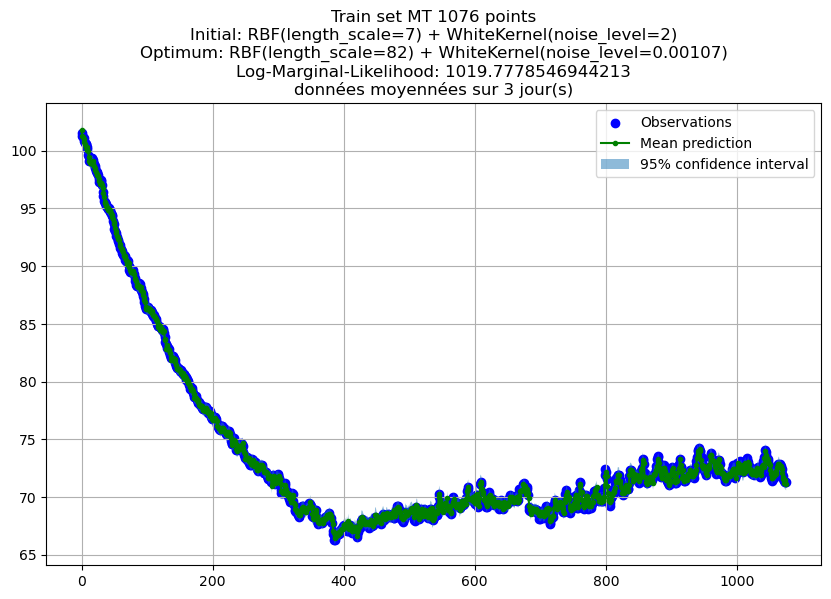

In [25]:
fig, ax = plot_training(X_train, y_mt_train, mean_prediction_mt, std_prediction_mt, gpr_mt, kernel_mt, "Train set MT")

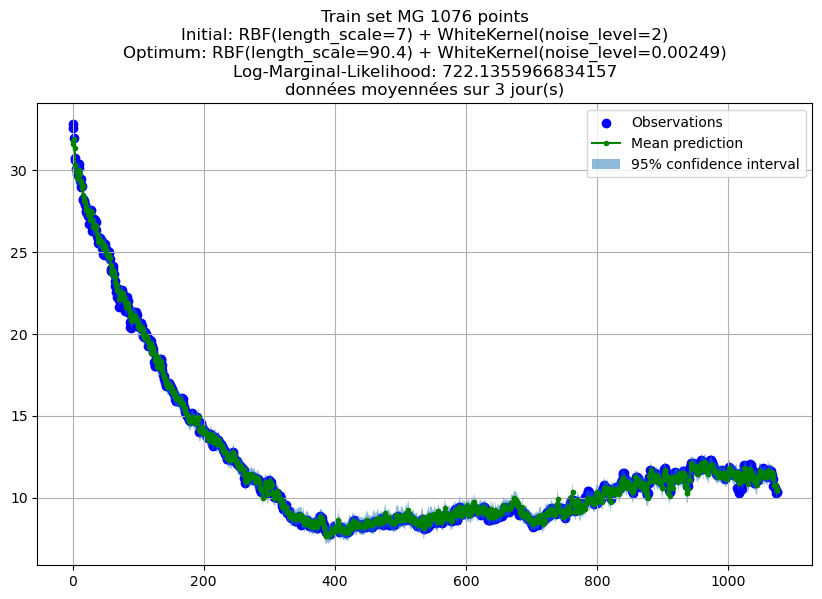

In [26]:
fig, ax = plot_training(X_train, y_mg_train, mean_prediction_mg, std_prediction_mg, gpr_mg, kernel_mg, "Train set MG")

In [28]:
# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


print(f"Train set : MAE MT = {mean_absolute_error(y_mt_train, mean_prediction_mt)}")
print(f"Train set : MSE MT = {mean_squared_error(y_mt_train, mean_prediction_mt)}")
print(f"Train set : MAE MG = {mean_absolute_error(y_mg_train, mean_prediction_mg)}")
print(f"Train set : MSE MG = {mean_squared_error(y_mg_train, mean_prediction_mg)}")

Train test : MAE MT = 0.16517188954522335
Train test : MSE MT = 0.04654963930408081
Train test : MAE MG = 0.16536750020978208
Train test : MSE MG = 0.04969582115590163


### Inférences J+1

In [29]:
def plot_inference(X_test, y_test, y_mean, y_std, gpr, kernel, titre):
    """utility function pour afficher perf sur test set avec CI"""
    
    fig, ax = plt.subplots(figsize=(10,6))

    abscisses = np.arange(X_test.shape[0])
    ax.scatter(abscisses, y_test, marker='o', label="Observations", color='blue')
    ax.plot(abscisses, y_mean, marker='.', label="Mean prediction", color='green')
    ax.set_title(
        titre +\
        f" {X_test.shape[0]} points\n" +\
        f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: " +\
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}\n" +\
        f"données moyennées sur {length_average} jour(s)"
    )
    ax.grid(True)
    ax.fill_between(
        abscisses,
        y_mean - 1.96 * y_std,
        y_mean + 1.96 * y_std,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    
    return fig, ax

In [30]:
mean_prediction_mt, std_prediction_mt = gpr_mt.predict(X_test, return_std=True)

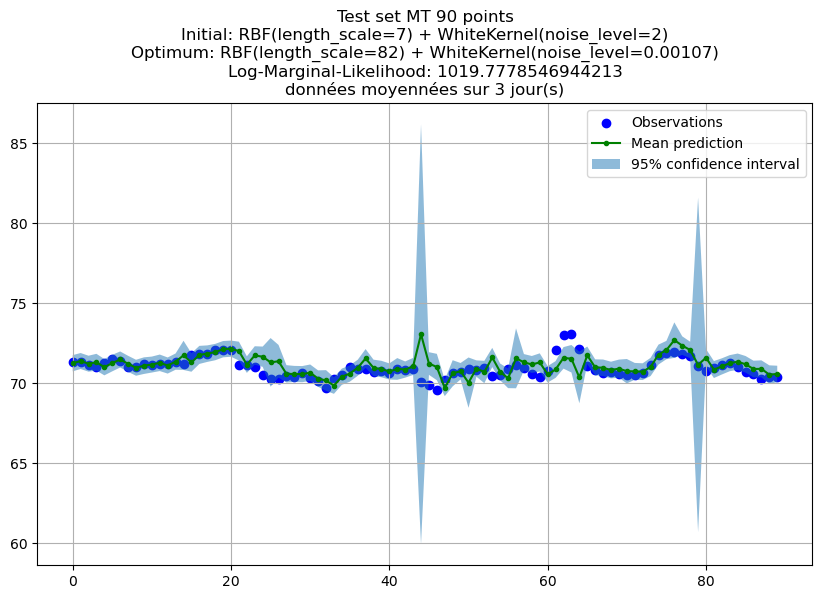

In [31]:
fig, ax = plot_inference(X_test, y_mt_test, mean_prediction_mt, std_prediction_mt, gpr_mt, kernel_mt, "Test set MT J+1")

In [32]:
mean_prediction_mg, std_prediction_mg = gpr_mg.predict(X_test, return_std=True)

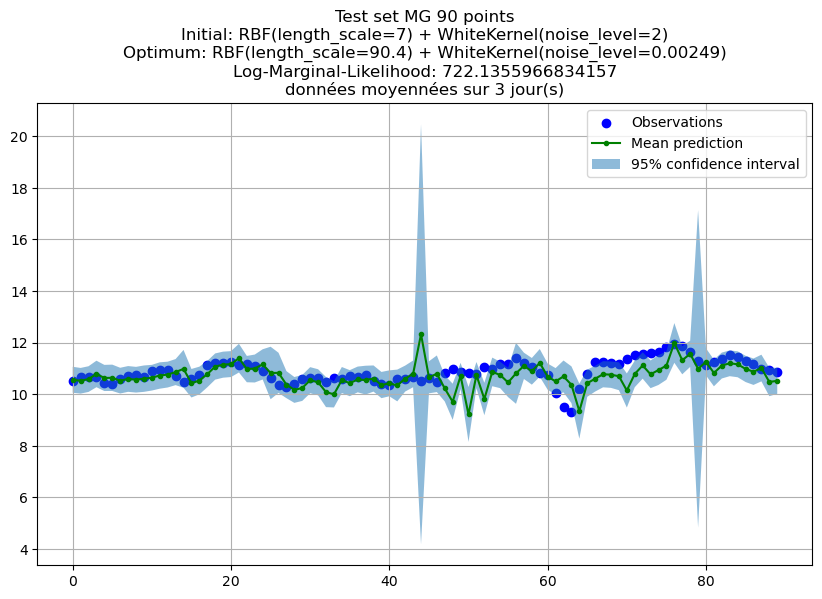

In [33]:
fig, ax = plot_inference(X_test, y_mg_test, mean_prediction_mg, std_prediction_mg, gpr_mg, kernel_mg, "Test set MG J+1")

In [34]:
print(f"Test set J+1 : MAE MT = {mean_absolute_error(y_mt_test, mean_prediction_mt)}")
print(f"Test set J+1 : MSE MT = {mean_squared_error(y_mt_test, mean_prediction_mt)}")
print(f"Test set J+1 : MAE MG = {mean_absolute_error(y_mg_test, mean_prediction_mg)}")
print(f"Test set J+1 : MSE MG = {mean_squared_error(y_mg_test, mean_prediction_mg)}")

Test set J+1 : MAE MT = 0.4125065868378665
Test set J+1 : MSE MT = 0.4116330664814061
Test set J+1 : MAE MG = 0.3580577297361326
Test set J+1 : MSE MG = 0.2548684700171479


### Inférence J+1 à J+N

In [35]:
# horizon de prédiction
horizon = 30

In [36]:
X_test

,MT,MG,Cals,Exos
2023-08-22,71.274524,10.363810,1894.600000,175.004572
2023-08-23,71.320655,10.522083,1880.033333,278.436046
2023-08-24,71.313433,10.665046,1841.766667,234.717606
2023-08-25,71.117194,10.666380,1708.766667,173.100913
2023-08-26,71.011593,10.669852,1744.000000,164.274231
...,...,...,...,...
2023-11-15,71.032963,11.449259,1778.100000,154.334501
2023-11-16,70.715139,11.291944,1741.266667,262.986866
2023-11-17,70.573234,11.174907,1716.266667,192.706969
2023-11-18,70.243512,10.989167,1727.833333,139.096440


In [37]:
X_test_pred = X_test[:horizon].copy(deep=True)

In [38]:
y_pred_mt = []  # prédiction MT
y_pred_mg = []  # prédiction MG
y_pred_mt_std = []  # écart-type prédiction MT
y_pred_mg_std = []  # écart-type prédiction MG

# initialisation des valeurs de départ
next_mt = X_test_pred.iloc[0,0]
next_mg = X_test_pred.iloc[0,1]

In [39]:
for r in range(len(X_test_pred)):
    # on extrait les inputs du jour et on remplace les valeurs MT, MG du jour par celles prédites
    row = X_test_pred.iloc[r:r+1,:].copy(deep=True)
    mini_X_test = pd.DataFrame(
        data = { 'MT' : next_mt,
                'MG' : next_mg,
                'Cals' : row['Cals'],
                'Exos' : row['Exos']}
    )
    # on prédit MT à J+1
    pred_mt, pred_mt_std = gpr_mt.predict(mini_X_test, return_std=True)
    next_mt = pred_mt[0]
    y_pred_mt.append(next_mt)
    y_pred_mt_std.append(pred_mt_std[0])
    # on prédit MG à J+1
    pred_mg, pred_mg_std = gpr_mg.predict(mini_X_test, return_std=True)
    next_mg = pred_mg[0]
    y_pred_mg.append(next_mg)
    y_pred_mg_std.append(pred_mg_std[0])

In [40]:
y_pred_mt_std = np.array(y_pred_mt_std)
y_pred_mg_std = np.array(y_pred_mg_std)

In [41]:
def plot_inference_horizon(X_test, y_test, y_mean, y_std, gpr, kernel, titre):
    """utility function pour afficher perf sur test set avec CI"""
    
    fig, ax = plt.subplots(figsize=(10,6))

    abscisses = np.arange(X_test.shape[0])
    ax.scatter(abscisses, y_test[:horizon], marker='o', label="Observations", color='blue')
    ax.plot(abscisses, y_mean, marker='.', label="Mean prediction", color='green')
    ax.set_title(f"Test set {X_test.shape[0]} points. Inférence J+2 avec valeur prédite à J+1\n" f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
        f"{gpr_mt.log_marginal_likelihood(gpr.kernel_.theta)}\n" \
            f"données moyennées sur {length_average} jours" 
    )
    ax.grid(True)
    ax.fill_between(
        abscisses,
        y_mean - 1.96 * y_std,
        y_mean + 1.96 * y_std,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    
    return fig, ax

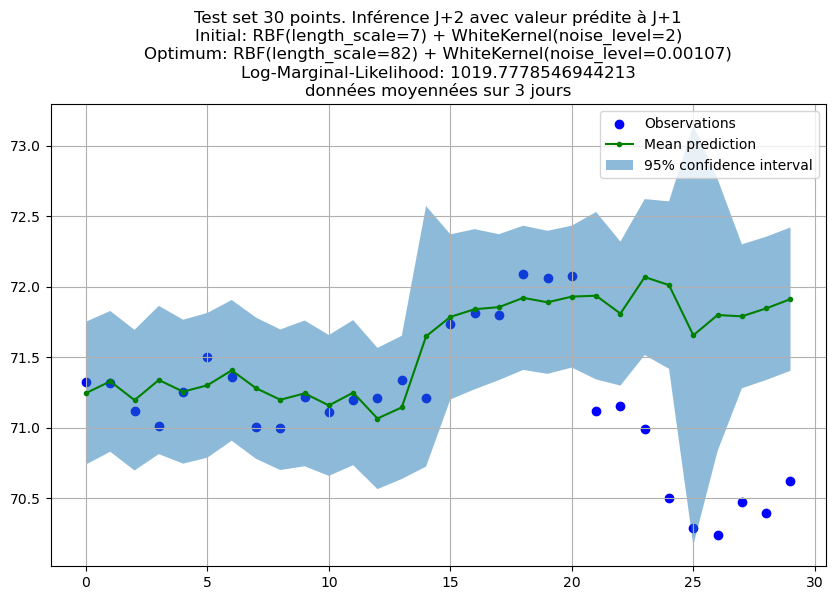

In [42]:
fig, ax = plot_inference_horizon(X_test_pred, y_mt_test, y_pred_mt, y_pred_mt_std, gpr_mt, kernel_mt, "Prediction longue MT")

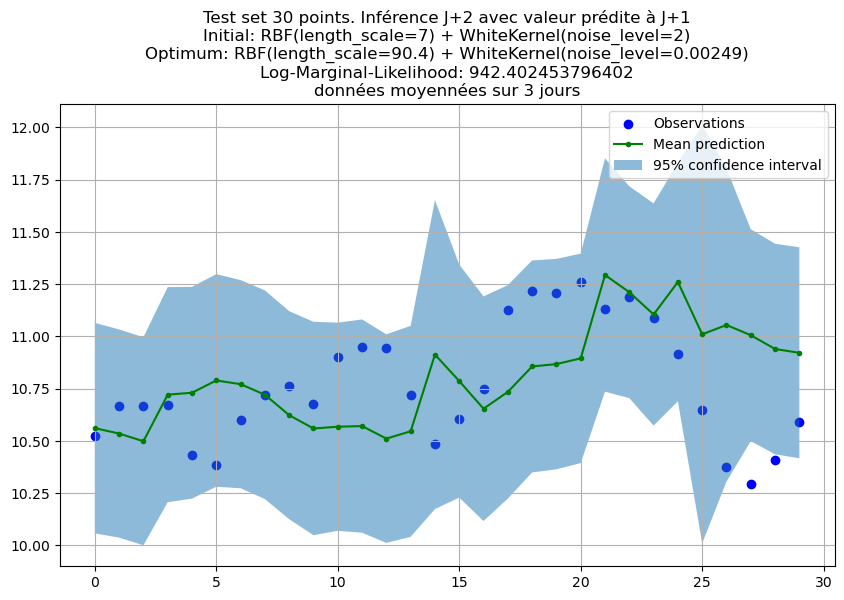

In [43]:
fig, ax = plot_inference_horizon(X_test_pred, y_mg_test, y_pred_mg, y_pred_mg_std, gpr_mg, kernel_mg, "Prediction longue MG")

In [46]:
print(f"Test set J+{horizon} : MAE MT = {mean_absolute_error(y_mt_test[:horizon], y_pred_mt)}")
print(f"Test set J+{horizon} : MSE MT = {mean_squared_error(y_mt_test[:horizon], y_pred_mt)}")
print(f"Test set J+{horizon} : MAE MG = {mean_absolute_error(y_mg_test[:horizon], y_pred_mg)}")
print(f"Test set J+{horizon} : MSE MG = {mean_squared_error(y_mg_test[:horizon], y_pred_mg)}")

Test set J+30 : MAE MT = 0.4606139044878096
Test set J+30 : MSE MT = 0.49947642044166085
Test set J+30 : MAE MG = 0.2719949850711905
Test set J+30 : MSE MG = 0.10765311959418518
